In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection

import pylab
import time
import random
import matplotlib.pyplot as plt


# Detection of input drift using PSI

* Used publically available SEA dataset
* Has three features and 2 classes (0 and 1)
* Data set consists of 60,000 rows

In [11]:
def get_decile_dist(prediction_prob_matrix):
    prob_0 = prediction_prob_matrix[:,0]
    df_prob_0 = pd.DataFrame(prob_0, columns = ['prob_0'])
    conditions = [(df_prob_0.prob_0 >= 0.9),
          ((df_prob_0.prob_0 < 0.9) & (df_prob_0.prob_0 >= 0.8)),
          ((df_prob_0.prob_0 < 0.8) & (df_prob_0.prob_0 >= 0.7)),
          ((df_prob_0.prob_0 < 0.7) & (df_prob_0.prob_0 >= 0.6)),
          ((df_prob_0.prob_0 < 0.6) & (df_prob_0.prob_0 >= 0.5)),
          ((df_prob_0.prob_0 < 0.5) & (df_prob_0.prob_0 >= 0.4)),
          ((df_prob_0.prob_0 < 0.4) & (df_prob_0.prob_0 >= 0.3)),
          ((df_prob_0.prob_0 < 0.3) & (df_prob_0.prob_0 >= 0.2)),
          ((df_prob_0.prob_0 < 0.2) & (df_prob_0.prob_0 >= 0.1)),
          (df_prob_0.prob_0 < 0.1)]

    choices = np.arange(1,11)
    df_prob_0['decile'] = np.select(conditions, choices, default = 'none')
    df_prob_0['decile'] = df_prob_0['decile'].astype(int)
    decile_dist = df_prob_0.groupby('decile')[['prob_0']].count().reset_index().sort_values(by = 'decile')
    decile_dist['decile_dist_perc'] = np.round(100*decile_dist['prob_0']/decile_dist['prob_0'].sum(),1)
    return decile_dist

    

In [12]:
def calculate_PSI(training_set, serving_set, model_recv):
    predictions_train = model_recv.predict_proba(training_set)
    training_dist = get_decile_dist(predictions_train).rename(columns = {'prob_0' : 'train_dist', 
                                                                         'decile_dist_perc' : 'train_dist_perc'})
    predictions_serving = model_recv.predict_proba(serving_set)
    serving_dist = get_decile_dist(predictions_serving).rename(columns = {'prob_0' : 'serv_dist', 
                                                                          'decile_dist_perc' : 'serv_dist_perc'})
    merged = pd.merge(training_dist, serving_dist, on='decile', how ='inner')
    
    merged['s-t'] = merged['serv_dist_perc'] - merged['train_dist_perc']

    merged['ln(s/t)'] = np.log(merged['serv_dist_perc']/merged['train_dist_perc'])

    merged['PSI'] = merged['ln(s/t)'] * (merged['s-t']/100)

    return merged.PSI.sum()
    

In [13]:
def train_model(X,y):
    seed = 369
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model_new = GaussianNB()
    model_new.fit(X_train, y_train)
    y_pred = model_new.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy after retraining: %.2f%%" % (accuracy * 100.0))
    return model_new,X_test
    
    

In [14]:
df = pd.read_csv('data/sea.csv', names = ['feature1','feature2','feature3','label'])

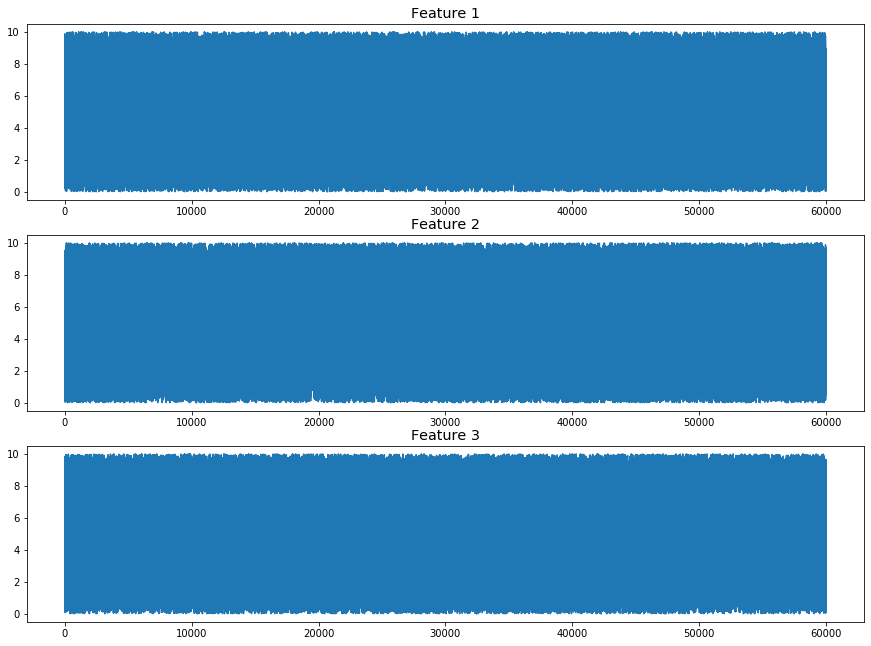

In [8]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=3)
# features = ['feature1','feature2','feature3']

fig = plt.figure(figsize = (15,11))

plt.subplot(3, 1, 1)
plt.plot(df['feature1'], label = 'feature1')
plt.title('Feature 1', fontsize = 'x-large')

plt.subplot(3, 1, 2)
plt.plot(df['feature2'], label = 'feature2')
plt.title('Feature 2', fontsize = 'x-large')

plt.subplot(3, 1, 3)
plt.plot(df['feature3'], label = 'feature3')
plt.title('Feature 3', fontsize = 'x-large')

# plt.subplot(2, 2, 4)
# plt.plot(x, y)
plt.savefig('figs/manual_feature_SEA.png')
plt.show()


<img src="window.png">

# Train classifier (logistic regression) on first 15000 examples

In [15]:
df1 = df[0:15000]

In [16]:
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
# fit model no training data
model = GaussianNB()
model.fit(X1_train, y1_train)
print(model)

GaussianNB(priors=None, var_smoothing=1e-09)


In [17]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=4369)
cv_results = model_selection.cross_validate(model, X1_train, y1_train, cv=kfold, scoring=scoring)
clf = model.fit(X1_train, y1_train)
cv_results

{'fit_time': array([0.00100398, 0.00102925, 0.00199962, 0.00099802, 0.00199986]),
 'score_time': array([0.01099944, 0.0049715 , 0.00599718, 0.00500011, 0.00500274]),
 'test_accuracy': array([0.86965174, 0.8761194 , 0.87860697, 0.86865672, 0.88159204]),
 'test_precision_weighted': array([0.87080661, 0.87822715, 0.88134715, 0.87029596, 0.88272164]),
 'test_recall_weighted': array([0.86965174, 0.8761194 , 0.87860697, 0.86865672, 0.88159204]),
 'test_f1_weighted': array([0.86626973, 0.87233507, 0.8751201 , 0.86513759, 0.87889145]),
 'test_roc_auc': array([0.85363623, 0.87006699, 0.87520178, 0.87803119, 0.89321188])}

## Average accuracy with cross validation (5 splits) on inititial test set

In [20]:
mean_acc = 100 * cv_results['test_accuracy'].mean()
print("The mean accuracy of model is %0.2f " %mean_acc) 

The mean accuracy of model is 87.49 


In [21]:
# make predictions for test data
y1_pred = model.predict(X1_test)
# predictions = [round(value) for value in y_pred]
predictions = model.predict_proba(X1_test)

## Monitor PSI  vs accuracy - without intervention

In [16]:

# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt

Initial model accuracy: 86.81%


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


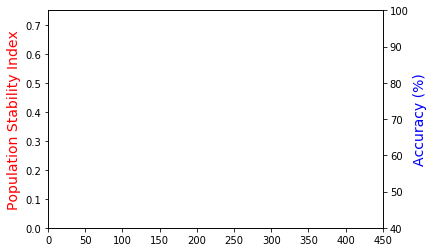

In [23]:
## Initiate model
df1 = df[0:15000]
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = GaussianNB()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))

batch_size = 100
window_size = 15000
# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-window_size)/batch_size)+1):
    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1', 'feature2', 'feature3']].values
    y2 = df_temp['label'].values

    PSIs.append(calculate_PSI(X1_test,X2,model))
    y2_pred = model.predict(X2)
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0,0.75])
    ax2.set_ylim([40,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.00001)
    

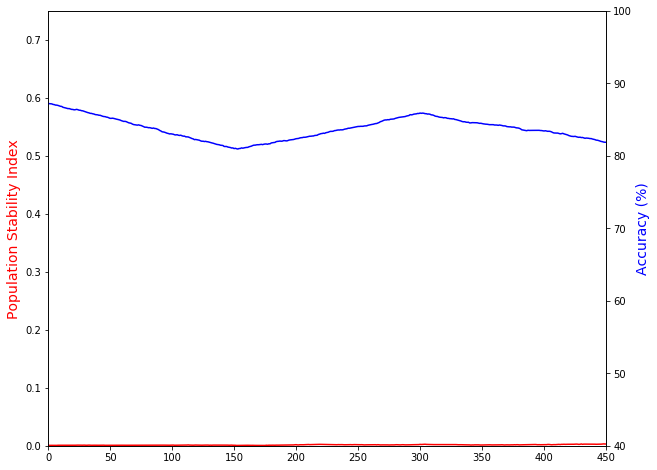

In [25]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax.set_ylim([0,0.75])
ax2.set_ylim([40,100])
ax.plot(range(len(PSIs)),PSIs, color = 'red')
ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/ADWIN_wo_intervention.png')
plt.show()


In [26]:
np.mean(acc)

83.77751662971174

## Monitor accuracy with intervention at PSI >0.05

Initial model accuracy: 89.27%


C:\Users\t910571\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


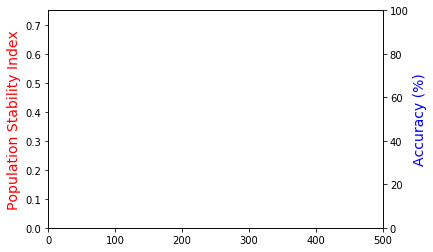

Accuracy after retraining: 89.76%
Accuracy after retraining: 88.94%
Accuracy after retraining: 88.52%


In [21]:
batch_size = 100
window_size = 10000
## Initiate model
df1 = df[0:window_size]
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = LogisticRegression()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))




# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-window_size)/batch_size)+1):

    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1', 'feature2', 'feature3']].values
    y2 = df_temp['label'].values
#     PSIs.append(calculate_PSI(X1_test,df[i*batch_size,(i*batch_size)+window_size],model))
    PSI_new = calculate_PSI(X1_test,X2,model)
    PSIs.append(PSI_new)
    y2_pred = model.predict(X2)
#     print((100*accuracy_score(y2, y2_pred)))
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0,0.75])
    ax2.set_ylim([0,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.001)
    
    if PSI_new>0.05:
        model,new_ref_df = train_model(X2,y2)
#         print("new PSI = ", calculate_PSI(X2,X2,model))
        X1_test = X2
        

        

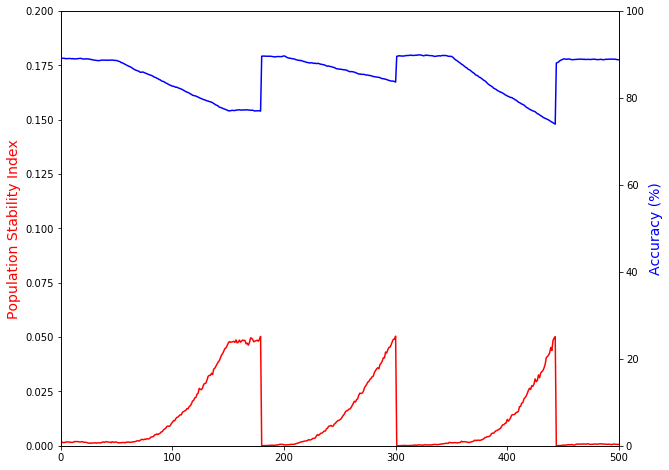

In [25]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
ax2=ax.twinx()
ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
ax.set_ylim([0,0.2])
ax2.set_ylim([0,100])
ax.plot(range(len(PSIs)),PSIs, color = 'red')
ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
ax2.plot(range(len(acc)),acc, color = 'blue')
ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)
plt.savefig('figs/PSI_w_intervention.png')

In [26]:
np.mean(acc)

85.20788423153692